In [12]:
import libraries as lib
import geopandas as gpd
import pandas as pd
import rasterio as rio
import xarray as xr

!pip install openpyxl
import openpyxl

In [13]:
import os
from pathlib import Path
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import xrspatial.multispectral as ms
from xrspatial.focal import mean, focal_stats, hotspots
import stackstac
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from collections import OrderedDict
from shapely.geometry import shape
import rioxarray
from rasterio.crs import CRS
from rasterio.plot import show
import rasterio.features
import itertools
import cartopy.crs as ccrs
import rioxarray
import dask.array as da
import joblib
import xarray as xr
from geopandas import GeoDataFrame
from pandas import Series
from xarray import Dataset
from flox.xarray import xarray_reduce
import warnings

In [21]:
Yasa_34kn = gpd.read_file("yasa_34knots.geojson").fillna(0).to_crs("EPSG:3857")
Yasa_50kn = gpd.read_file("yasa_50knots.geojson").fillna(0).to_crs("EPSG:3857")
Yasa_64kn = gpd.read_file("yasa_64knots.geojson").fillna(0).to_crs("EPSG:3857")

In [22]:
print(Yasa_34kn.crs)
print(Yasa_50kn.crs)
print(Yasa_64kn.crs)

EPSG:3857
EPSG:3857
EPSG:3857


In [23]:
bbox = gpd.read_file("bbox_fiji.geojson")
bbox = bbox.to_crs("EPSG:3857")


In [24]:
fiji_land = gpd.read_file("fiji-land.geojson").fillna(0).to_crs("EPSG:3857")
fiji_land['m2'] = fiji_land.geometry.area
fiji_land['km2'] = fiji_land['m2']/1000000
fiji_land

,GID_0,COUNTRY,geometry,m2,km2
0,FJI,Fiji,"MULTIPOLYGON (((19826705.183 -2173693.199, 198...",2.095516e+10,20955.162737


In [25]:
# Check for invalid geometries in fiji_land
invalid_fiji_land = fiji_land[~fiji_land.is_valid]
if not invalid_fiji_land.empty:
    print("Invalid geometries in fiji_land:")
    print(invalid_fiji_land)

# Check for invalid geometries in Yasa_34kn
invalid_Yasa_34kn = Yasa_34kn[~Yasa_34kn.is_valid]
if not invalid_Yasa_34kn.empty:
    print("Invalid geometries in Yasa_34kn:")
    print(invalid_Yasa_34kn)

In [26]:
import geopandas as gpd
from shapely.geometry import mapping

# Clip the raster with the extracted geometries
land_Yasa_34kn = gpd.clip(fiji_land, Yasa_34kn)
land_Yasa_50kn = gpd.clip(fiji_land, Yasa_50kn)
land_Yasa_64kn = gpd.clip(fiji_land, Yasa_64kn)

In [27]:
# Save areas m2
land_Yasa_34kn['m2'] = land_Yasa_34kn.geometry.area
land_Yasa_50kn['m2'] = land_Yasa_50kn.geometry.area
land_Yasa_64kn['m2'] = land_Yasa_64kn.geometry.area

# Save areas km2
land_Yasa_34kn['km2'] = land_Yasa_34kn['m2']/1000000
land_Yasa_50kn['km2'] = land_Yasa_50kn['m2']/1000000
land_Yasa_64kn['km2'] = land_Yasa_64kn['m2']/1000000

,GID_0,COUNTRY,geometry,m2,km2
0,FJI,Fiji,"MULTIPOLYGON (((19823187.376 -2088429.827, 198...",1.926489e+10,19264.890912


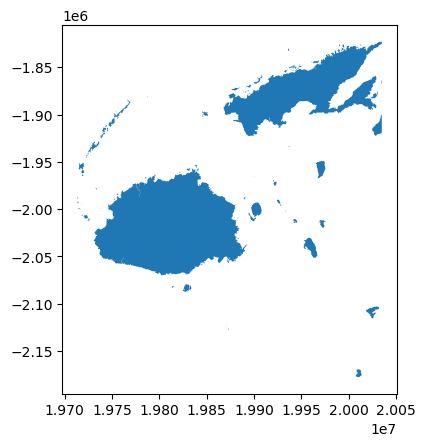

In [28]:
land_Yasa_34kn.plot()
land_Yasa_34kn

,GID_0,COUNTRY,geometry,m2,km2
0,FJI,Fiji,"MULTIPOLYGON (((19834596.956 -1960342.072, 198...",6.851531e+09,6851.530736


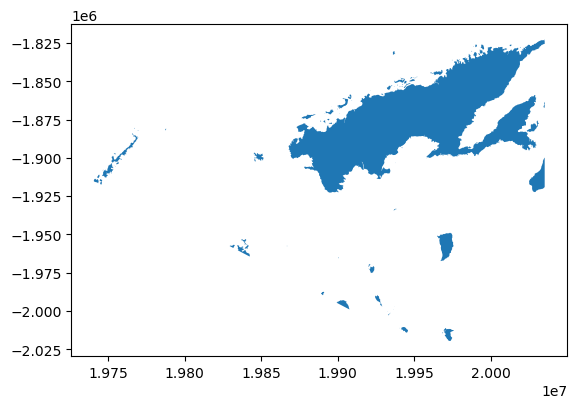

In [29]:
land_Yasa_50kn.plot()
land_Yasa_50kn

,GID_0,COUNTRY,geometry,m2,km2
0,FJI,Fiji,"MULTIPOLYGON (((19938372.881 -1933504.051, 199...",6.508513e+09,6508.512635


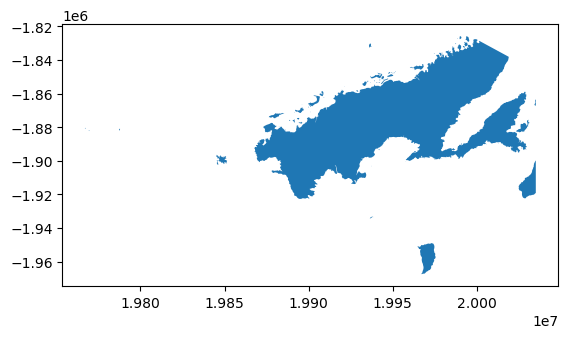

In [30]:
land_Yasa_64kn.plot()
land_Yasa_64kn

In [31]:
Yasa_df = pd.concat([land_Yasa_34kn, land_Yasa_50kn, land_Yasa_64kn], axis=0)
# concatenated_df['Tropical Cyclone'] = ['TC Pam Vanuatu (2015)', 'TC Yasa Vanuatu (2020)', 'TC Winston Fiji (2016)', 'TC Yasa Fiji (2020)', 'TC Yasa Fiji (2021)']
Yasa_df['TC'] = "TC Yasa (2020)"
Yasa_df

,GID_0,COUNTRY,geometry,m2,km2,TC
0,FJI,Fiji,"MULTIPOLYGON (((19823187.376 -2088429.827, 198...",1.926489e+10,19264.890912,TC Yasa (2020)
0,FJI,Fiji,"MULTIPOLYGON (((19834596.956 -1960342.072, 198...",6.851531e+09,6851.530736,TC Yasa (2020)
0,FJI,Fiji,"MULTIPOLYGON (((19938372.881 -1933504.051, 199...",6.508513e+09,6508.512635,TC Yasa (2020)
